# 🧬 OpenFDA Structure Analysis Notebook

This notebook analyzes the structure of the OpenFDA adverse event reports dataset, which contains thousands of semi-structured records in JSON format.
The goal is to fully understand the data schema to guide an effective relational SQL schema design.

### Key Questions Addressed:
- How many reports are there, and are there duplicates?
- What fields exist across all reports, and how consistently are they used?
- Which fields are deeply nested or contain repeated elements (1:N relationships)?
- How variable is the structure between reports?
- Are there list-type fields beyond just dictionaries?
- Which fields are categorical, sparse, or contain explicit nulls?

The insights from this notebook will be used to construct and justify a normalized SQL schema for the dataset.

## 🔍 Notebook Structure Overview

This notebook follows a systematic structure analysis pipeline:

0. **Dataset preparation** – load data from JSON and stream report-by-report
1. **Count reports and check for duplicate IDs**
2. **Extract all unique field paths from the dataset**
3. **Analyze structural variability across reports**
4. **Deeper structure analysis:**
   - 4.1 Group fields by nested prefix
   - 4.2 Identify 1:N relationships (list of dicts)
   - 4.3 Analyze field co-occurrence (correlation heatmap)
   - 4.4 Identify sparse (low-presence) fields
   - 4.5 Identify all list-type fields (including lists of strings)
   - 4.6 Identify categorical and binary fields
   - 4.7 Detect explicit null values in reports

Each step contributes to designing an accurate, efficient, and normalized SQL schema.

In [58]:
import os
import glob
import ijson
from collections import Counter, defaultdict
import pandas as pd
from typing import Any, Dict
from tqdm import tqdm
import seaborn as sns


### Initialize the path to the dataset:

In [24]:
data_path = "../data/raw/source_data"

## Function for iterating over the reports in the dataset:

In [23]:
def iterate_reports_ijson(path):
    """Yields one report at a time from the 'results' array inside the full dataset,
    iterating over all .json files if a directory is provided."""
    
    def yield_file(file_path):
        with open(file_path, 'rb') as f:
            parser = ijson.items(f, 'results.item')
            for report in parser:
                yield report

    if os.path.isdir(path):
        for file_path in sorted(glob.glob(os.path.join(path, '*.json'))):
            yield from yield_file(file_path)
    else:
        yield from yield_file(path)


## 1. Counting the number of reports and identifying duplicates.

In [27]:
from tqdm import tqdm

report_count = 0
unique_ids = set()
duplicate_count = 0

for report in tqdm(iterate_reports_ijson(data_path), desc="Scanning reports"):
    report_count += 1
    report_id = report.get("safetyreportid")
    if report_id in unique_ids:
        duplicate_count += 1
    else:
        unique_ids.add(report_id)

print(f"📦 Total reports scanned: {report_count}")
print(f"🔁 Duplicate reports found: {duplicate_count}")
print(f"✅ Unique reports: {len(unique_ids)}")

Scanning reports: 36000it [05:12, 115.30it/s]

📦 Total reports scanned: 36000
🔁 Duplicate reports found: 0
✅ Unique reports: 36000


## 2. Collect all unique keys across the dataset

In this step, we extract every unique field path found in the dataset, including deeply nested keys inside arrays (e.g., `patient.drug`, `patient.reaction`).  
This helps us understand the full schema and guides table design decisions.

In [34]:
def extract_key_set(report):
    """Returns a set of unique flattened keys from a nested JSON object."""
    key_set = set()
    def collect(obj, prefix=''):
        if isinstance(obj, dict):
            for k, v in obj.items():
                full_key = f"{prefix}.{k}" if prefix else k
                key_set.add(full_key)
                collect(v, full_key)
        elif isinstance(obj, list):
            for item in obj:
                collect(item, prefix)
    collect(report)
    return key_set

# Run key analysis
all_keys = set()
max_keys = 0
max_report_id = None

for report in tqdm(iterate_reports_ijson(data_path), desc="Collecting unique keys"):
    keys = extract_key_set(report)
    all_keys.update(keys)
    if len(keys) > max_keys:
        max_keys = len(keys)
        max_report_id = report.get("safetyreportid")

print(f"✅ Total unique keys across dataset: {len(all_keys)}")
print(f"📈 Max number of keys in a single report: {max_keys} (report ID: {max_report_id})")


✅ Total unique keys across dataset: 93
📈 Max number of keys in a single report: 91 (report ID: 23269553)


In [35]:
# Step 1: Build key frequency across all reports
key_counter = defaultdict(int)

for report in tqdm(iterate_reports_ijson(data_path), desc="Counting key frequencies"):
    keys = extract_key_set(report)
    for k in keys:
        key_counter[k] += 1

# Step 2: Convert to DataFrame
key_df = pd.DataFrame({
    "field_path": list(key_counter.keys()),
    "presence_count": list(key_counter.values())
})

key_df["presence_percent"] = key_df["presence_count"] / len(unique_ids) * 100
key_df.sort_values("presence_percent", ascending=False, inplace=True)

# View top fields
key_df.head(10)

Counting key frequencies: 36000it [05:46, 103.76it/s]


,field_path,presence_count,presence_percent
56,primarysource,36000,100.0
58,transmissiondate,36000,100.0
36,fulfillexpeditecriteria,36000,100.0
40,patient.reaction,36000,100.0
27,patient.drug.drugcharacterization,36000,100.0
45,safetyreportid,36000,100.0
48,serious,36000,100.0
23,receivedate,36000,100.0
20,receiptdateformat,36000,100.0
53,sender.sendertype,36000,100.0


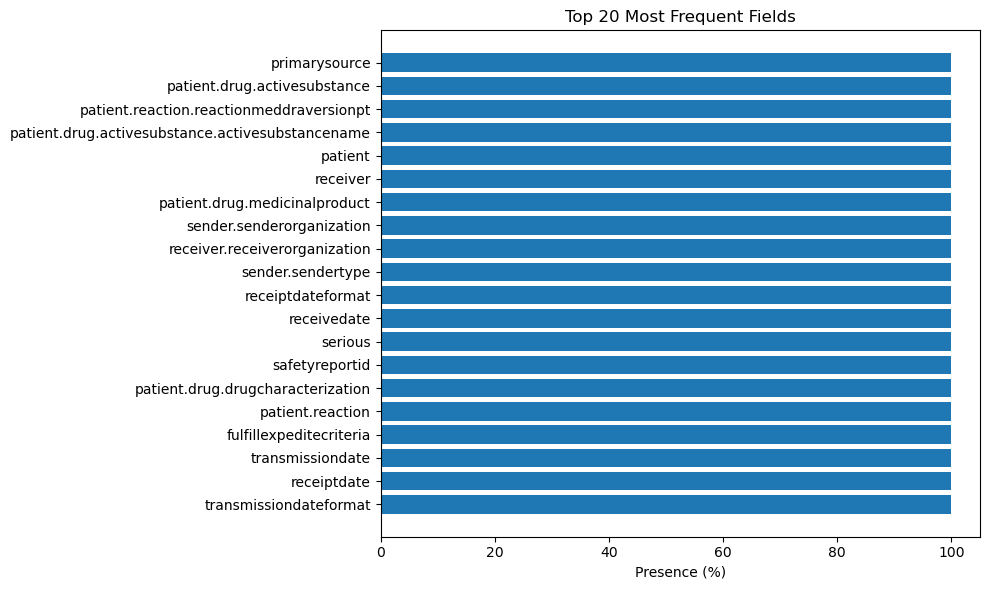

In [36]:
import matplotlib.pyplot as plt

# Top 20 fields
top_n = 20
plt.figure(figsize=(10, 6))
plt.barh(key_df.head(top_n).sort_values("presence_percent")["field_path"],
         key_df.head(top_n).sort_values("presence_percent")["presence_percent"])
plt.xlabel("Presence (%)")
plt.title(f"Top {top_n} Most Frequent Fields")
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()

In [37]:
# Save key frequencies to CSV
key_df.to_csv("../reports/evaluation_results/all_unique_keys.csv", index=False)
print("✅ Exported unique keys with presence stats to all_unique_keys.csv")

✅ Exported unique keys with presence stats to all_unique_keys.csv


In [38]:
key_df.shape

(93, 3)

## 3. Analyze key set distribution across reports

Now that we know the full set of unique keys, we examine the variability of key presence in individual reports.  

We focus on:
- How many unique keys each report contains
- Whether reports follow similar or distinct structures
- Identifying the most common field combinations across reports


In [39]:
# Initialize
key_counts = []
key_set_freq = Counter()

# Collect per-report key sets
for report in tqdm(iterate_reports_ijson(data_path), desc="Analyzing key structure per report"):
    keys = extract_key_set(report)
    key_counts.append(len(keys))
    key_set_freq[frozenset(keys)] += 1

print(f"📊 Number of distinct report shapes (unique key sets): {len(key_set_freq)}")
print(f"📈 Average number of keys per report: {sum(key_counts) / len(key_counts):.2f}")


Analyzing key structure per report: 36000it [05:18, 112.89it/s]

📊 Number of distinct report shapes (unique key sets): 16653
📈 Average number of keys per report: 71.65


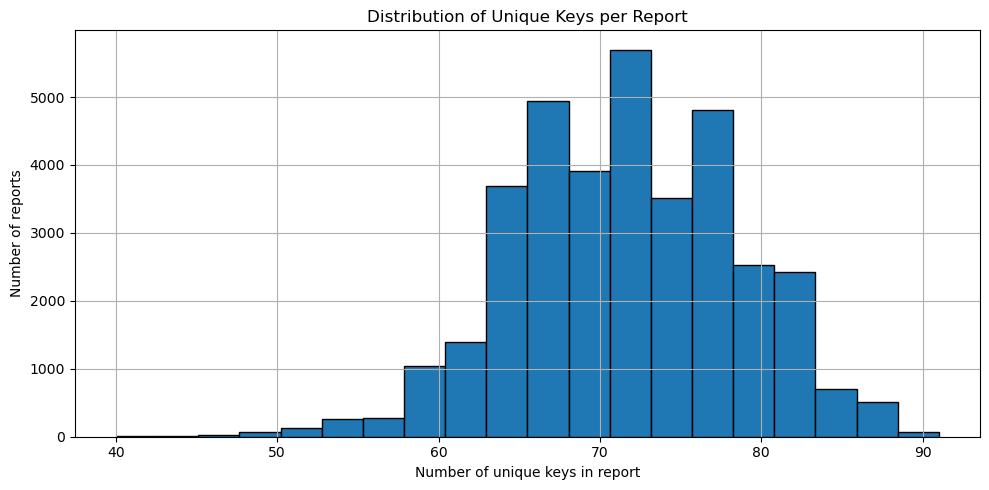

In [40]:
plt.figure(figsize=(10, 5))
plt.hist(key_counts, bins=20, edgecolor='black')
plt.xlabel("Number of unique keys in report")
plt.ylabel("Number of reports")
plt.title("Distribution of Unique Keys per Report")
plt.grid(True)
plt.tight_layout()
plt.show()


In [44]:
# Show top 50 most common key sets
print("Top 50 most common report structures:")
for key_set, freq in key_set_freq.most_common(50):
    print(f"{freq} reports share this structure with {len(key_set)} keys.")


Top 50 most common report structures:
390 reports share this structure with 69 keys.
333 reports share this structure with 80 keys.
331 reports share this structure with 76 keys.
241 reports share this structure with 82 keys.
185 reports share this structure with 63 keys.
164 reports share this structure with 79 keys.
146 reports share this structure with 61 keys.
116 reports share this structure with 78 keys.
115 reports share this structure with 66 keys.
111 reports share this structure with 73 keys.
109 reports share this structure with 68 keys.
96 reports share this structure with 71 keys.
93 reports share this structure with 77 keys.
92 reports share this structure with 83 keys.
91 reports share this structure with 68 keys.
88 reports share this structure with 58 keys.
86 reports share this structure with 71 keys.
84 reports share this structure with 75 keys.
82 reports share this structure with 64 keys.
81 reports share this structure with 80 keys.
80 reports share this structure

## 4.1 Field frequency grouped by nesting prefix

To better understand how fields are distributed within logical groups,  
we group field paths by their top-level or mid-level prefixes (e.g., `patient.drug.*`, `sender.*`, `receiver.*`).

This helps identify:
- Which field groups are complex enough to deserve separate tables
- Which groups are sparsely populated or redundant


In [49]:


def group_field_prefixes(df, max_depth=2):
    """Group fields by their dot-separated prefix (up to a depth)."""
    prefix_stats = defaultdict(list)
    
    for _, row in df.iterrows():
        full_path = row["field_path"]
        prefix = ".".join(full_path.split(".")[:max_depth])
        prefix_stats[prefix].append({
            "field": full_path,
            "presence_count": row["presence_count"],
            "presence_percent": row["presence_percent"]
        })
    
    summary = []
    for prefix, fields in prefix_stats.items():
        summary.append({
            "prefix": prefix,
            "num_fields": len(fields),
            "avg_presence": sum(f["presence_percent"] for f in fields) / len(fields),
            "min_presence": min(f["presence_percent"] for f in fields),
            "max_presence": max(f["presence_percent"] for f in fields)
        })
    
    return pd.DataFrame(summary).sort_values("avg_presence", ascending=False)

# Run prefix grouping (FIXED to match your notebook variable)
prefix_summary = group_field_prefixes(key_df, max_depth=2)

prefix_summary.shape

# Display top field groups
prefix_summary.head(10)



,prefix,num_fields,avg_presence,min_presence,max_presence
0,primarysource,1,100.0,100.0,100.0
20,receiver.receivertype,1,100.0,100.0,100.0
18,receivedateformat,1,100.0,100.0,100.0
17,primarysource.reportercountry,1,100.0,100.0,100.0
16,sender,1,100.0,100.0,100.0
15,transmissiondateformat,1,100.0,100.0,100.0
14,receiptdate,1,100.0,100.0,100.0
13,patient,1,100.0,100.0,100.0
12,receiver,1,100.0,100.0,100.0
11,sender.senderorganization,1,100.0,100.0,100.0


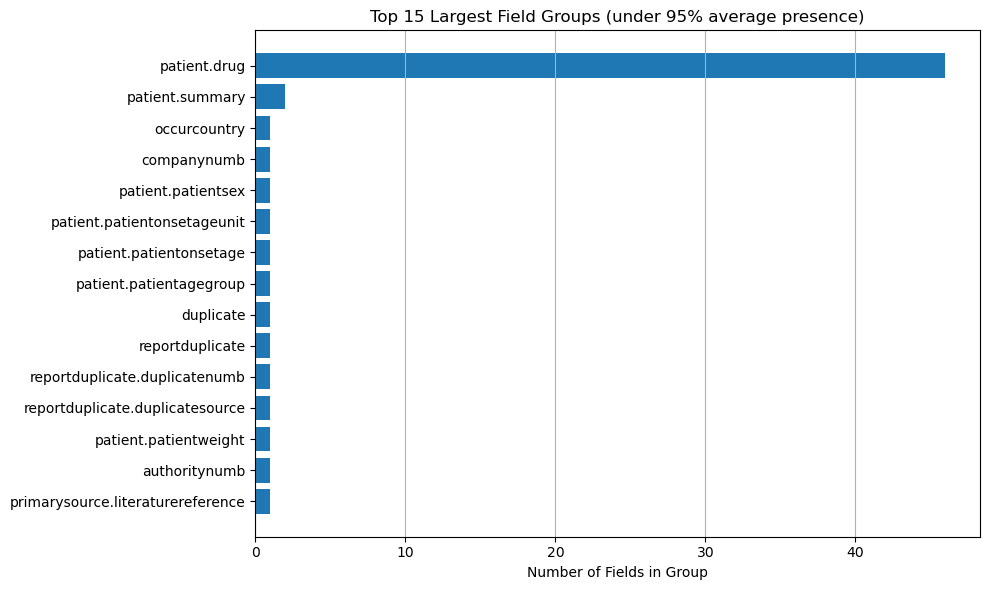

In [52]:
# Filter out almost-always-present groups and sort by number of fields
filtered_prefixes = prefix_summary[prefix_summary["avg_presence"] < 95]
top_n = 15
top_filtered = filtered_prefixes.sort_values("num_fields", ascending=False).head(top_n)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(top_filtered["prefix"], top_filtered["num_fields"])
plt.xlabel("Number of Fields in Group")
plt.title(f"Top {top_n} Largest Field Groups (under 95% average presence)")
plt.grid(axis='x')
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()


In [53]:
# Save the field group summary to CSV for reference
prefix_summary.to_csv("../reports/evaluation_results/field_group_summary.csv", index=False)
print("✅ Exported field group summary to: reports/evaluation_results/field_group_summary.csv")


✅ Exported field group summary to: reports/evaluation_results/field_group_summary.csv


## 4.2 Identify 1:N (one-to-many) structures

Some fields in the dataset contain lists of objects (e.g., `patient.drug`, `patient.reaction`).  
These are classic one-to-many structures and should typically be modeled as separate tables  
in a relational schema.

In this step, we:
- Traverse reports and identify fields whose values are lists of dictionaries
- Count how often they occur and how many items they contain per report


In [56]:
from collections import defaultdict

# Dictionary to store field -> list of lengths (number of sub-items)
list_field_lengths = defaultdict(list)

# Scan a sample of reports
max_reports = report_count  # You can raise this if needed
for i, report in enumerate(tqdm(iterate_reports_ijson(data_path), desc="Scanning for 1:N structures")):
    if i >= max_reports:
        break
    def scan(obj, path=""):
        if isinstance(obj, dict):
            for k, v in obj.items():
                full_path = f"{path}.{k}" if path else k
                scan(v, full_path)
        elif isinstance(obj, list):
            if all(isinstance(item, dict) for item in obj) and obj:
                list_field_lengths[path].append(len(obj))
    scan(report)

# Summarize into a DataFrame
list_fields_summary = pd.DataFrame([
    {
        "field": field,
        "reports_with_field": len(lengths),
        "avg_items_per_report": sum(lengths) / len(lengths),
        "max_items_in_any_report": max(lengths)
    }
    for field, lengths in list_field_lengths.items()
]).sort_values("reports_with_field", ascending=False)

list_fields_summary.head(10)


Scanning for 1:N structures: 36000it [05:09, 116.37it/s]


,field,reports_with_field,avg_items_per_report,max_items_in_any_report
0,patient.reaction,36000,3.501361,147
1,patient.drug,36000,5.245750,1377
2,reportduplicate,5581,4.721914,426


## 4.3 Correlation of key presence across fields

Some fields in the dataset often appear together (e.g., `sender.sendertype` and `sender.senderorganization`),  
while others may be mutually exclusive or only rarely co-occur.

This step calculates pairwise correlations of field presence across reports, helping us:
- Identify fields that could be grouped into the same table
- Spot conditional or redundant fields
- Understand structural dependencies


Rebuilding presence matrix: 0it [00:00, ?it/s]

Rebuilding presence matrix: 36000it [04:21, 137.69it/s]


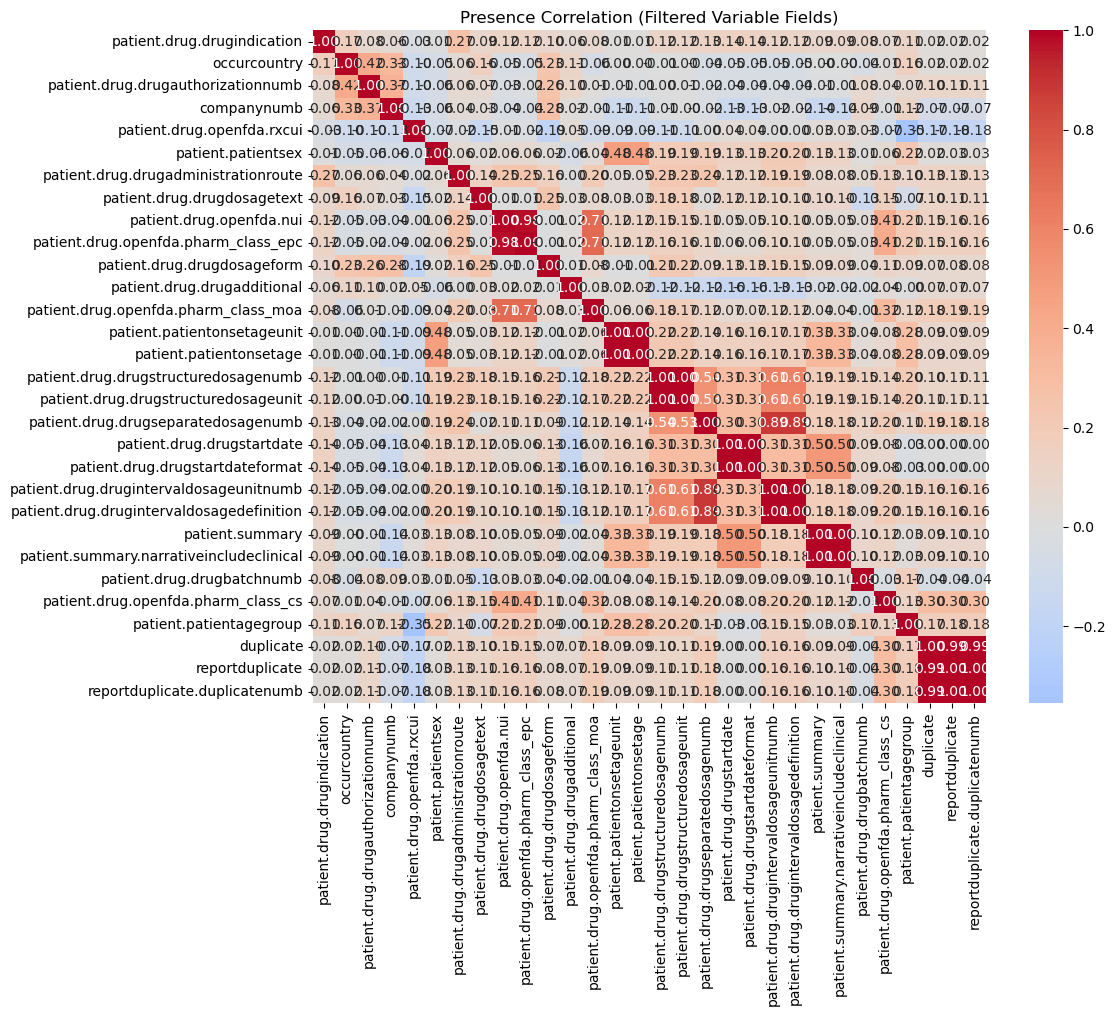

In [61]:
# Filter fields with some presence variation (e.g. 5%–95%)
variable_fields = key_df[
    (key_df["presence_percent"] > 5) & (key_df["presence_percent"] < 95)
].sort_values("presence_count", ascending=False).head(30)["field_path"].tolist()

# Rebuild matrix for variable fields
presence_data = []
for report in tqdm(iterate_reports_ijson(data_path), desc="Rebuilding presence matrix"):
    row = {}
    keys = extract_key_set(report)
    for field in variable_fields:
        row[field] = int(field in keys)
    presence_data.append(row)

presence_df = pd.DataFrame(presence_data)

# Correlation and heatmap
corr_matrix = presence_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap="coolwarm", center=0, annot=True, fmt=".2f", square=True)
plt.title("Presence Correlation (Filtered Variable Fields)")
plt.tight_layout()
plt.show()


## 4.4 Null density analysis

In this step, we examine how often each field is missing from the dataset.  
Fields with low presence may:
- Be excluded from the primary schema
- Be moved to auxiliary or optional tables
- Represent edge-case data

We compute and visualize field sparsity based on presence percentages.


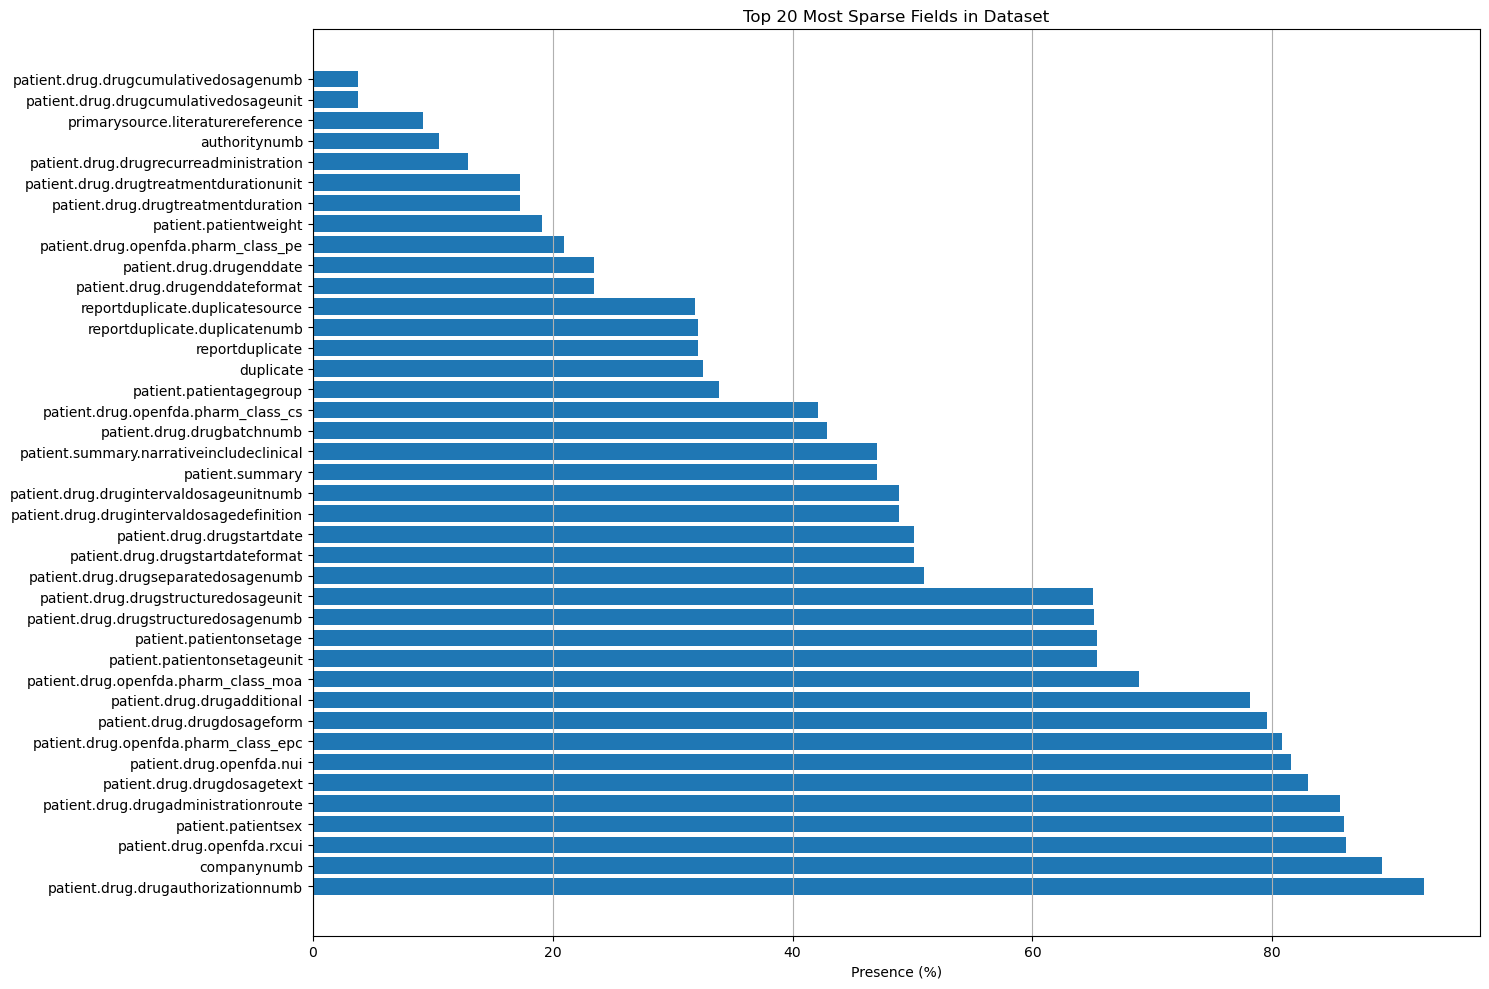

In [ ]:
# Sort fields by presence percent ascending (most sparse first)
sparse_fields = key_df.sort_values("presence_percent").head(40)

# Bar chart of sparsity
plt.figure(figsize=(15, 10))
plt.barh(sparse_fields["field_path"], sparse_fields["presence_percent"])
plt.xlabel("Presence (%)")
plt.title("Top 40 Most Sparse Fields in Dataset")
plt.grid(axis='x')
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()


In [69]:
# Sort by ascending presence and export top 40 sparse fields
sparse_export = key_df.sort_values("presence_percent").head(40)
sparse_export.to_csv("../reports/evaluation_results/sparse_fields_top40.csv", index=False)
print("✅ Exported sparse fields to: reports/evaluation_results/sparse_fields_top40.csv")


✅ Exported sparse fields to: reports/evaluation_results/sparse_fields_top40.csv


## 4.5 Analyze all list-type fields (not just list of dictionaries)

So far we only explored 1:N relationships based on fields that store a list of dictionaries.  
However, some fields may contain lists of primitives (e.g., strings, numbers) or mixed types,  
and could still be important for schema design or data modeling.

In this step, we:
- Identify all fields in the dataset that contain lists
- Record what types are found in those lists
- Count how frequently each list-type field appears and how long the lists are


In [73]:
list_field_types = defaultdict(set)
list_field_lengths = defaultdict(list)

# Enhanced recursive scan
for i, report in enumerate(tqdm(iterate_reports_ijson(data_path), desc="Scanning nested list-type fields")):
    def scan(obj, path=""):
        if isinstance(obj, dict):
            for k, v in obj.items():
                full_path = f"{path}.{k}" if path else k
                scan(v, full_path)
        elif isinstance(obj, list):
            if not obj:
                return
            list_field_types[path].update({type(item).__name__ for item in obj})
            list_field_lengths[path].append(len(obj))
            for item in obj:
                scan(item, path)  # Recurse into each item, maintaining the list's path
    scan(report)

# Summarize list-type fields again
list_profile_df = pd.DataFrame([
    {
        "field": path,
        "type_set": ", ".join(sorted(types)),
        "reports_with_field": len(lengths),
        "avg_items_per_report": sum(lengths) / len(lengths),
        "max_items_in_any_report": max(lengths)
    }
    for path, types in list_field_types.items()
    for path2, lengths in list_field_lengths.items()
    if path == path2
]).sort_values("reports_with_field", ascending=False)

list_profile_df.head



Scanning nested list-type fields: 36000it [04:27, 134.46it/s]


<bound method NDFrame.head of                                       field type_set  reports_with_field  \
3           patient.drug.openfda.brand_name      str              160347   
4         patient.drug.openfda.generic_name      str              160347   
5    patient.drug.openfda.manufacturer_name      str              160347   
6          patient.drug.openfda.product_ndc      str              160347   
7         patient.drug.openfda.product_type      str              160347   
11              patient.drug.openfda.spl_id      str              160347   
12          patient.drug.openfda.spl_set_id      str              160347   
13         patient.drug.openfda.package_ndc      str              160347   
2   patient.drug.openfda.application_number      str              158001   
8                patient.drug.openfda.route      str              157708   
14                patient.drug.openfda.unii      str              157678   
9       patient.drug.openfda.substance_name      str      

In [74]:
list_profile_df

,field,type_set,reports_with_field,avg_items_per_report,max_items_in_any_report
3,patient.drug.openfda.brand_name,str,160347,10.859187,1284
4,patient.drug.openfda.generic_name,str,160347,1.411439,132
5,patient.drug.openfda.manufacturer_name,str,160347,16.266210,493
6,patient.drug.openfda.product_ndc,str,160347,47.913581,1391
7,patient.drug.openfda.product_type,str,160347,1.070123,2
11,patient.drug.openfda.spl_id,str,160347,31.867587,1314
12,patient.drug.openfda.spl_set_id,str,160347,31.867587,1314
13,patient.drug.openfda.package_ndc,str,160347,110.586141,4169
2,patient.drug.openfda.application_number,str,158001,8.637287,72
8,patient.drug.openfda.route,str,157708,1.540784,11


In [76]:
list_profile_df.to_csv("../reports/evaluation_results/all_list_fields_profile.csv", index=False)
print("✅ Exported list field profile to: reports/evaluation_results/all_list_fields_profile.csv")


✅ Exported list field profile to: reports/evaluation_results/all_list_fields_profile.csv


## 4.6 Detect categorical and binary fields

This step identifies fields that contain only a small number of unique values  
across all reports. These include:
- Binary fields (e.g., `"Y"/"N"`, `"M"/"F"`, `"1"/"2"`)
- Categorical fields (e.g., `"age group"`, `"reporter country"`)

Fields like these can be optimized in a SQL schema using:
- Boolean columns
- Enums
- Foreign key lookup tables (if values are standardized)

We will:
- Scan all scalar (non-list) fields
- Collect unique values and frequencies
- Report fields with a small number of distinct values


In [85]:
value_sets = defaultdict(set)
max_reports = report_count  # You can raise this if needed

for i, report in enumerate(tqdm(iterate_reports_ijson(data_path), desc="Rescanning raw report values")):
    if i >= max_reports:
        break
    def scan(obj, path=""):
        if isinstance(obj, dict):
            for k, v in obj.items():
                full_path = f"{path}.{k}" if path else k
                scan(v, full_path)
        elif not isinstance(obj, list):  # ignore lists
            value_sets[path].add(str(obj).strip())

    scan(report)

# Filter for categorical candidates
categorical_fields = []
for k, v in value_sets.items():
    if 1 < len(v) <= 30:
        categorical_fields.append({
            "field": k,
            "num_unique": len(v),
            "unique_values": sorted(v)
        })

# Output
df_categoricals = pd.DataFrame(categorical_fields).sort_values("num_unique")
print(f"✅ Found {len(df_categoricals)} categorical fields.")
df_categoricals.head(15)

Rescanning raw report values: 36000it [05:08, 116.74it/s]

✅ Found 14 categorical fields.


,field,num_unique,unique_values
0,transmissiondate,2,"[20240409, 20240410]"
2,serious,2,"[1, 2]"
3,seriousnessdeath,2,"[1, 2]"
4,seriousnesslifethreatening,2,"[1, 2]"
5,seriousnesshospitalization,2,"[1, 2]"
6,seriousnessdisabling,2,"[1, 2]"
7,seriousnesscongenitalanomali,2,"[1, 2]"
8,seriousnessother,2,"[1, 2]"
1,reporttype,3,"[1, 2, 3]"
12,patient.patientsex,3,"[0, 1, 2]"


In [87]:
df_categoricals.to_csv("../reports/evaluation_results/categorical_fields_summary.csv", index=False)
print("✅ Exported categorical fields to: reports/evaluation_results/categorical_fields_summary.csv")


✅ Exported categorical fields to: reports/evaluation_results/categorical_fields_summary.csv


## 4.7 Detect explicit null values in source reports

To distinguish structural variability (missing keys) from intentional absence (null values),  
we now scan all fields for explicit `null` values in the raw data.

This helps ensure:
- Our SQL schema design correctly handles NULLs
- We don’t misinterpret variability as data loss

In [89]:
null_fields = Counter()
max_reports = report_count  # or run across full set if time allows

for i, report in enumerate(tqdm(iterate_reports_ijson(data_path), desc="Scanning for explicit nulls")):
    if i >= max_reports:
        break
    def scan(obj, path=""):
        if isinstance(obj, dict):
            for k, v in obj.items():
                full_path = f"{path}.{k}" if path else k
                if v is None:
                    null_fields[full_path] += 1
                else:
                    scan(v, full_path)
        elif isinstance(obj, list):
            for item in obj:
                scan(item, path)

    scan(report)

# Output sorted by frequency
null_df = pd.DataFrame(null_fields.items(), columns=["field", "null_count"]).sort_values("null_count", ascending=False)
print(f"✅ Found {len(null_df)} fields with explicit nulls.")
# null_df.head(15)


Scanning for explicit nulls: 36000it [04:47, 125.09it/s]

✅ Found 0 fields with explicit nulls.


## ✅ Summary of Structural Insights

This concludes the structural analysis of the OpenFDA adverse event dataset.  
Key findings:

- 36,000 unique reports scanned, no duplicate `safetyreportid`s detected
- 93 unique fields identified across all reports
- Over 16,000 distinct structural formats (unique key sets per report)
- Core 1:N structures: `patient.drug`, `patient.reaction`, `reportduplicate`
- Numerous list-type fields (including `list[str]`) nested in `patient.drug.openfda` should be normalized
- Sparse fields identified for possible NULL handling or auxiliary table design
- Categorical fields detected (e.g., `patientsex`, `serious`, `reporttype`) suitable for booleans, enums, or lookups
- ✅ No explicit `null` values found in the source JSON — any NULLs in SQL will reflect missing fields, not raw nulls

**Next step:** begin designing the relational SQL schema.
